<a href="https://colab.research.google.com/github/ChasteloveCNN/MSBA2022/blob/main/13A_Gensim_Doc2Vec_and_Tok2Vec_Example_COMPLETE_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Putting the Lego Pieces Together - Topic Modeling (Top2Vec)

![](https://raw.githubusercontent.com/ddangelov/Top2Vec/master/images/doc_word_embedding.svg?sanitize=true)

### Resources

- https://github.com/ddangelov/Top2Vec
- https://radimrehurek.com/gensim/models/doc2vec.html


### Intuition

- Train word and document vectors jointly
- With the same space, use dimensionality reduction
- cluster points
- use the closest N tokens to the center to identify the keywords to help frame the topic for the cluster

In [ ]:
# installs
! pip install umap-learn

     |████████████████████████████████| 86 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 48.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=030d83107e859ec8579d1e7495a750f1cb7e15afd693a5648477b63bf78264f9
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=47ce7a89cfb4df425d3741fafc3e3ddef86c912b6c692fe8ba026105c40620f4
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [ ]:
# imports
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy
from spacy import cli

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

from umap import UMAP

In [ ]:
# spacy small model
model = "en_core_web_sm"
cli.download(model)
nlp = spacy.load(model)

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
# get the airline intents
# air = pd.read_gbq("SELECT * from `questrom.datasets.airline-intents`", "questrom")
df = pd.read_gbq("SELECT * from `questrom.datasets.topics`", "questrom")

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=jcZaIj3Y1QHtGvgJKIOS5FDOG04jvU&prompt=consent&access_type=offline


In [ ]:
df.shape

In [ ]:
df.sample(3)

# Build the Model

In [ ]:
# make a list of tagged docs
# the docs say to use the index as the label, so we will follow that approach

# extracting just the tokenizer, thats all we care about
tokenizer = nlp.tokenizer

def tokenize(text):
  doc = tokenizer(text)
  return [token.text for token in doc]

df['tokens'] = df.text.str.strip().apply(tokenize)




In [ ]:
df.head(3)

,id,text,topic,tokens
0,1,I'm going to be out of the country for about a...,Shipping,"[I, 'm, going, to, be, out, of, the, country, ..."
1,2,I was wondering if you'd be able to overnight ...,Shipping,"[I, was, wondering, if, you, 'd, be, able, to,..."
2,3,The Swingline electronic stapler (472555) look...,Shipping,"[The, Swingline, electronic, stapler, (, 47255..."


In [ ]:
tokens = df.tokens.to_list()
docs = [TaggedDocument(t, [str(i)]) for i, t in enumerate(tokens)]
docs[0]

TaggedDocument(words=['I', "'m", 'going', 'to', 'be', 'out', 'of', 'the', 'country', 'for', 'about', 'a', 'week', ',', 'but', 'before', 'I', 'travel', 'I', "'m", 'going', 'to', 'be', 'getting', 'the', 'animal', 'print', 'jumper', ',', 'product', 'code', 'T383434J.', 'Can', 'I', 'have', 'this', 'held', 'at', 'the', 'post', 'office', 'or', 'a', 'distribution', 'centre', 'for', 'pickup', '?', 'I', "'d", 'just', 'hate', 'to', 'have', 'it', 'sitting', 'at', 'my', 'house', 'when', 'I', "'m", 'not', 'going', 'to', 'be', 'around', '.'], tags=['0'])

In [ ]:
# lets setup the model
# https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html
# If dm=1 means ‘distributed memory’ (PV-DM) and dm =0 means ‘distributed bag of words’ (PV-DBOW). Distributed Memory model preserves the word order in a document whereas Distributed Bag of words just uses the bag of words approach, which doesn’t preserve any word order.
model = Doc2Vec(vector_size=50, min_count=2, epochs=40, dm=1)

In [ ]:
# setup the vocabulary
model.build_vocab(docs)

In [ ]:
# train
model.train(docs, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
# # what is the size of our vocab?

len(model.wv.vocab)

4231

In [ ]:
# get a predicted document vector
dv = model.infer_vector(tokens[0])

In [ ]:
dv.shape

(50,)

In [ ]:
dv

array([-0.18060349, -0.7797983 , -0.07528827, -0.30421507, -1.1698989 ,
       -0.30718115, -0.13548371, -0.2177858 ,  0.3816725 ,  0.40093687,
        0.15048517,  0.5407088 ,  0.532066  ,  0.619948  , -0.5068819 ,
       -0.06365155,  0.7687812 ,  0.37296116, -0.3217831 , -0.07805105,
        0.5796331 , -0.5409556 , -0.01579339, -0.24863361, -0.16741402,
        0.1600232 , -0.4715238 , -0.36747095,  0.39724362, -0.02597511,
       -0.1265035 , -0.38647994,  0.23288693, -0.42488584,  0.21710415,
        0.85499793, -0.32232425, -0.53739166, -0.6475286 , -0.28937954,
       -0.00145683, -1.0210332 ,  0.5029759 ,  0.98788804, -0.8597865 ,
       -0.99883175,  0.10064248,  0.31253394, -0.65430456, -0.65363365],
      dtype=float32)

In [ ]:
# save the model
model.save("d2v.model")

# load the model
model2 = Doc2Vec.load("d2v.model")


# Extract the Trained Word and Document Vectors

In [ ]:
# get the doc vectors -- we feed in the tokenized document as a list of tokens
dvs = [model.infer_vector(doc) for doc in tokens]

In [ ]:
len(dvs)

5000

In [ ]:
df.shape

(5000, 4)

In [ ]:
# now, get the vocabulary word vectors
words = model.wv.vocab.keys()
words

dict_keys(['I', "'m", 'going', 'to', 'be', 'out', 'of', 'the', 'country', 'for', 'about', 'a', 'week', ',', 'but', 'before', 'travel', 'getting', 'animal', 'print', 'jumper', 'product', 'code', 'Can', 'have', 'this', 'held', 'at', 'post', 'office', 'or', 'distribution', 'centre', 'pickup', '?', "'d", 'just', 'hate', 'it', 'sitting', 'my', 'house', 'when', 'not', 'around', '.', 'was', 'wondering', 'if', 'you', 'able', 'overnight', 'jacket', '(', 'Item', '#', ')', 'me', 'in', 'Trenton', 'NJ', 'The', 'electronic', 'stapler', 'looks', 'really', 'great', 'would', 'need', 'shipped', 'St.', 'Thomas', 'US', 'Virgin', 'Islands', 'Do', 'allow', 'that', 'is', 'considered', '"', 'international', 'shipping', 'think', 'bag', 'work', '!', 'However', 'do', 'know', 'how', 'long', 'take', 'send', 'Kings', 'Mountain', 'NC', 'Zip', ':', '28086', 'might', 'somewhat', 'hurry', 'so', 'thought', 'check', 'state', 'wristlet', '58818', 'center', 'ring', 'Stanley', 'Bostitch', 'When', 'estimated', 'delivery', 'd

In [ ]:
model.wv.get_vector("what")

array([-0.02264759, -4.6633573 ,  3.058421  , -0.5871129 ,  0.24694517,
       -4.9551587 , -1.3352386 ,  0.14635889, -0.04000574, -1.9246098 ,
       -0.6507876 , -0.23200956, -0.33422017, -1.5090854 , -1.4801227 ,
       -3.132685  , -0.36406106,  0.52542394, -5.375976  , -1.5378294 ,
       -4.313433  , -3.4501147 ,  5.3353505 ,  3.2658985 , -0.94215757,
        1.2576463 , -0.19744503, -0.6881295 ,  4.9623494 , -1.0149256 ,
        5.514855  , -2.4194968 , -1.9533268 , -5.382799  ,  3.124901  ,
       -1.6814408 , -0.00726553,  2.9220755 ,  5.9629664 ,  2.1071262 ,
        4.265064  , -1.1823575 , -5.3644357 ,  2.298822  ,  1.0006377 ,
       -4.840494  ,  3.1461365 , -2.513688  ,  4.492963  ,  4.818629  ],
      dtype=float32)

In [ ]:
# the word vectors
wvs = [model.wv.get_vector(k) for k in words]

In [ ]:
len(wvs)

4231

In [ ]:
wvs[0]

array([-0.66578275, -2.9085355 , -0.8829532 , -1.3695974 , -3.0093536 ,
        0.11377451,  0.16933656,  1.24299   , -1.17743   ,  0.681819  ,
        0.09339035,  0.7378738 ,  1.3957863 ,  0.81947744, -0.00586513,
        0.38987252,  1.4816715 , -1.9055747 , -1.8339379 , -1.741449  ,
        0.10645479, -0.83257025,  1.7034976 ,  0.5461462 ,  2.4657433 ,
        0.8028198 , -1.2343493 ,  0.6627121 , -0.01037148,  0.03171173,
        1.6893027 , -1.1769923 ,  2.073956  , -2.753812  , -0.7679636 ,
        0.39844677, -0.5212944 ,  0.56874615,  0.87439674, -0.8394293 ,
        2.6921666 ,  1.824566  , -0.42156827,  1.3652284 ,  0.45353165,
        0.5698006 , -0.5414234 , -0.15038237,  1.6272262 ,  0.9797865 ],
      dtype=float32)

In [ ]:
wvs_df = pd.DataFrame(wvs, index=words)

In [ ]:
wvs_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
I,-0.665783,-2.908535,-0.882953,-1.369597,-3.009354,0.113775,0.169337,1.242990,-1.177430,0.681819,0.093390,0.737874,1.395786,0.819477,-0.005865,0.389873,1.481671,-1.905575,-1.833938,-1.741449,0.106455,-0.832570,1.703498,0.546146,2.465743,0.802820,-1.234349,0.662712,-0.010371,0.031712,1.689303,-1.176992,2.073956,-2.753812,-0.767964,0.398447,-0.521294,0.568746,0.874397,-0.839429,2.692167,1.824566,-0.421568,1.365228,0.453532,0.569801,-0.541423,-0.150382,1.627226,0.979787
'm,1.055109,-3.000840,-0.399056,2.572651,-4.851067,0.091857,3.235703,-2.028651,-0.878493,-1.562155,-4.067506,1.707077,-0.207731,0.940640,-3.144282,2.999190,2.809795,2.553936,2.948460,1.153078,1.769837,-3.250307,0.584587,-1.696497,-0.840267,1.172861,-0.503997,1.984019,1.561508,-0.144384,0.343667,0.003175,4.074138,-1.201601,-0.407159,-0.580692,0.274542,-0.283369,3.164036,-3.689550,-1.436645,3.021754,3.424588,1.896585,-0.910668,0.345929,1.655473,-1.790173,0.099726,-1.727546
going,-1.532647,0.687205,-1.172105,-2.924064,-1.880414,-3.330269,2.123246,-4.227839,-2.074299,0.870421,-0.369283,-4.452753,2.344996,-4.249955,-1.290592,-1.479118,3.421518,-4.243465,4.914837,-3.020855,-3.929148,-0.285183,2.253672,-5.657436,0.079344,-1.041635,2.388338,-1.798242,-3.748515,0.942380,-0.619262,-1.135410,0.617020,-2.888299,-2.269797,4.645120,-3.699750,-0.394745,1.544836,3.625982,-2.685975,0.274550,2.530495,3.233850,-2.627238,-0.159984,2.322147,-2.999153,-0.867622,3.222203


In [ ]:
dvs_df = pd.DataFrame(dvs, index=df.text)

In [ ]:
dvs_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
text,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"I'm going to be out of the country for about a week, but before I travel I'm going to be getting the animal print jumper, product code T383434J. Can I have this held at the post office or a distribution centre for pickup? I'd just hate to have it sitting at my house when I'm not going to be around.",-0.397924,-0.711229,-0.206766,-0.292248,-1.119157,-0.105951,-0.068171,-0.333696,0.585937,0.232716,0.071605,0.466864,0.776836,0.594392,-0.303131,0.225748,0.791833,0.391250,-0.296013,-0.157301,0.552240,-0.591973,0.078812,-0.595828,-0.207775,0.240900,-0.358313,-0.265520,0.536214,0.065732,-0.222256,-0.424481,0.032220,-0.374234,0.194687,0.613478,-0.362810,-0.598106,-0.577620,-0.107723,-0.176314,-1.096189,0.458119,0.886780,-0.976766,-1.064614,0.170944,0.274478,-0.374297,-0.627254
"I was wondering if you'd be able to overnight a jacket (Item #5220032) to me in Trenton, NJ?",-0.206852,0.284589,0.404785,-0.532679,-0.474808,-0.310564,0.219496,0.188848,-0.275991,0.249352,0.449042,0.011301,-0.149904,0.088136,0.014674,0.144065,0.078241,-0.071032,0.062912,-0.454195,-0.076925,0.161092,0.401417,0.306182,0.268293,-0.271819,-0.043734,-0.043099,0.290342,0.011793,0.132232,-0.223202,0.101531,0.362835,-0.449859,0.116591,-0.551389,-0.314786,-0.259020,0.222367,-0.226770,-0.424320,0.262417,-0.284037,0.487949,-0.798868,0.302646,0.105831,-0.033192,0.197674
"The Swingline electronic stapler (472555) looks really great, but I would need to have it shipped to St. Thomas in the US Virgin Islands. Do you allow for that, or is that considered ""international"" shipping?",0.130263,-0.269477,-0.434476,-0.062013,-0.318142,0.083562,-0.246485,0.462324,0.342016,-0.287815,1.349640,-0.372900,-0.002771,0.401557,-0.129492,-0.259684,0.087434,0.367613,-0.971915,-0.182911,-0.059437,-0.532396,-0.750401,-0.049185,-0.029156,0.291362,-0.431958,-0.240089,-0.068290,-0.558748,-0.369938,-0.153024,0.131665,0.124103,0.017545,-0.096747,0.337980,-0.180721,-0.058636,-0.158403,-0.511942,-0.622224,0.418237,-0.222949,0.452603,-0.746245,-0.048576,-0.256337,0.297158,-0.086371


> What we have now are two dataframes (to keep things as intuitive as we can).  One is the document vectors, the other is the token vectors, which we will use after the clustering.

# Dimensionality Reduction and Clustering

In [ ]:
# first, apply umap
reducer = UMAP(random_state=82)

# umap knows how to handle a pandas dataframe
embeds = reducer.fit_transform(dvs_df)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
# confirm what we have
embeds.shape

(5000, 2)

In [ ]:
# lets ignore tests and just say k = 7
# arbitrary selection
km = KMeans(7)
km.fit(embeds)

preds = km.predict(embeds)


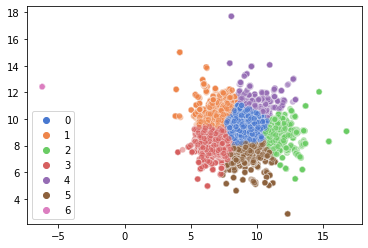

In [ ]:
# lets plot this
sns.scatterplot(x=embeds[:, 0], y=embeds[:, 1], hue=preds, alpha=.5, palette="muted")

In [ ]:
# ok, with the documents clustered, we are interested in learning
# about the words that are close/similar to the cluster centers

centers = km.cluster_centers_

centers.shape

(7, 2)

> Intuition:  We changed the embedding via UMAP, so to project the words into the same space, we need to transform the wvs too.

In [ ]:
wvs_umap = reducer.transform(wvs_df)

In [ ]:
# for each cluster, compare the center to the word embeddings via umap
# get the top 20 closest
# the umap embeddings for the word vectors is the lookup table
knn = NearestNeighbors(n_neighbors=15, metric="cosine")
knn.fit(wvs_umap)

NearestNeighbors(metric='cosine', n_neighbors=15)

In [ ]:
# get the top similar tokens for each cluster
nbrs = knn.kneighbors(centers, return_distance=False)

In [ ]:
# this should be the same length as clusters, and 10
nbrs.shape

(7, 15)

In [ ]:
# what do we have?
nbrs

array([[ 173,    6,  501, 1894, 1740,  496, 1092,  636, 2558, 3623, 1380,
        3178, 2267, 2313,  249],
       [2479, 3658, 1989, 4033,  838, 2904, 1429, 3796, 1449, 2083,  960,
         440,  990, 1765, 2573],
       [1728, 1360, 2151, 1389, 1559, 3415,  600, 3328,  777, 1878,  246,
         721,  638, 3135, 3736],
       [ 741,  174, 1402, 3409, 3024, 4201, 1331,  197, 1991,  335, 2944,
         958, 1716, 1731, 3019],
       [3532,  364, 1951, 2035, 3465, 1150,   27, 2981, 1630, 1091, 1113,
        1126, 2045, 3163,  224],
       [2000,  445,  738, 2175, 2891,  676,  486,  989, 1102, 3079, 2153,
        4073, 2795,  347, 2890],
       [2373, 2383, 1714, 1848,  485,   69, 2069, 1692, 1697, 1694, 1689,
        1733,   12, 1767,   83]])

> These are the indices for the word vectors.  We can use these to lookup the tokens

In [ ]:
# review the first cluster indexes
nbrs[0]

array([ 173,    6,  501, 1894, 1740,  496, 1092,  636, 2558, 3623, 1380,
       3178, 2267, 2313,  249])

In [ ]:
# loop for all clusters
topic_terms = []

for k in nbrs:
  topic_terms.append(wvs_df.iloc[k, :].index.to_list())

In [ ]:
for i, topic in enumerate(topic_terms):
  print((i, topic))

(0, ['Hi', 'of', 'Protein', 'Carolina', 'locations', 'shoes', 'Lamp', 'Optimum', 'entire', 'colors', 'bundle', 'lasts', 'larger', 'Energy', 'tomorrow'])
(1, ['1122985', 'known', 'Subtil', 'royal', 'beauty', 'brownie', 'Twill', 'sleeves', 'Washington', 'arctic', 'First', 'White', '15212', 'collection', 'short'])
(2, ['program', 'capsules', 'newsletter', 'Jacket', 'heel', 'connect', 'Men', 'hold', 'seen', 'seeing', 'ship', "'re", 'Women', 'height-', 'quartz'])
(3, ['booties', 'looking', 'Grill', 'calories', 'baby', 'biotin', 'actual', 'case', 'Sculpting', 'shirt', 'boys', 'Tote', 'types', 'oval', 'Flight'])
(4, ['reclined', 'NV', 'King', 'sofas', 'serving-', 'disposal', 'at', 'height', 'save', 'Floor', 'Oklahoma', 'Shorts', 'weekend', 'Both', 'mail'])
(5, ['65805', 'lives', 'certain', 'immediate', 'butter', 'possibly', 'am', 'Leather', 'Fit', 'lighter-', 'per', 'stretchy', 'bars', 'Lace', 'peanut'])
(6, ['winter', 'provider', 'bought', 'easier', 'ships', 'shipped', 'lights', 'blazers', '

# Summary and Next Steps

- Obviously no evaluation of the clusters - just chose 7 - is an area for improvement
- Really small corpus isn't helping.  It keeps things simple, but results aren't super clear
- However its important to consider how embeddings can be trained for different tasks, and in this case, jointly learned such that we can put tokens and documents in the same coordinate space for analysis!

> To me, topic modeling in general has always been something that I see people perform, but the results are never really clear to me, but the point is that an approach above makes much more sense to me in terms of howe we can relate similar items (document themes, words) to drive topic detection.  


## Top2Vec 

The mechanics we ran through above mirror the Top2Vec paper linked below 

- https://arxiv.org/abs/2008.09470
- https://github.com/ddangelov/Top2Vec

Differences:

1.  Used HDBScan for clustering, which has a nice property in that clusters do not need to be spherical in nature (like Kmeans)
1.  Certain records can be ouliers, that is, not part of a cluster


The result is that clusters might better identify micro topics for detection.

## Other Resources

- https://cssh.northeastern.edu/nulab/word-embedding-models-new-topic-models/
- https://www.storybench.org/how-news-media-are-setting-the-2020-election-agenda-chasing-daily-controversies-often-burying-policy/

